Error: 29.666605086130375
Error: 29.66660496463358
Error: 29.666604874584117
Error: 29.666604869680597
Error: 29.666604883946945
Error: 29.666604911984578
Error: 29.66660495384827
Error: 29.666605011110786
Error: 11.380419657595318
Error: 11.380419772612047
Error: 11.38041978151779
Error: 11.380419775810843
Error: 11.380419764476947
Error: 11.380419747696752
Error: 11.380419724886988
Error: 11.380419695198519
Error: 35.60376640854974
Error: 35.603766163397495
Error: 35.60376615210127
Error: 35.603766159547746
Error: 35.6037661801038
Error: 35.60376621356531
Error: 35.60376626127442
Error: 35.60376632535944
Error: 14.107371816032419
Error: 14.107371959559469
Error: 14.10737195914551
Error: 14.107371951034636
Error: 14.10737193735626
Error: 14.107371917849413
Error: 14.107371891791615
Error: 14.107371858232188
Error: 38.22452824367042
Error: 38.22452796765927
Error: 38.224527967716256
Error: 38.22452797950723
Error: 38.22452800276993
Error: 38.22452803865847
Error: 38.22452808905653
Erro

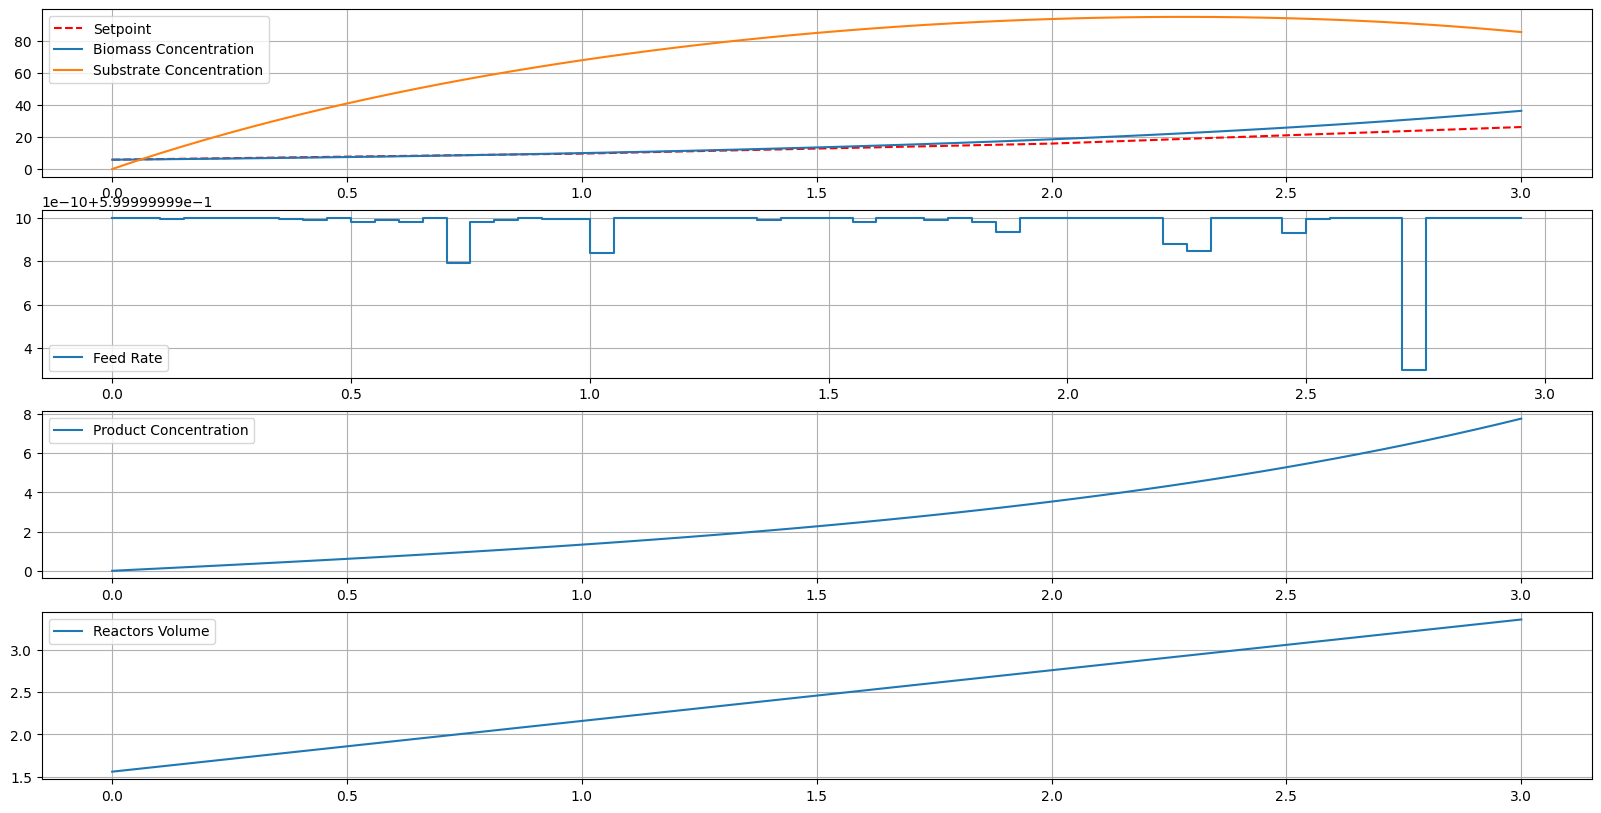

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#Παράμετροι συστήματος
params=[0.870,0.215,0.496,0.2] # mu_max [1/h], Ks [g/L], Yxs [g/g] , Ypx [g/g]

#Συγκέντρωση εισόδου υποστρώματος
Sin= 1.43*200 #g/L

#Αρχικές Συνθήκες
X0=5.85
S0=0.013
V0=1.56
P0=0

#Χρονικές Παράμετροι
T_START=0
T_END=3
TIME_RANGE=int(T_END-T_START)

#MPC παράμετροι
dt=0.05
SS=int(TIME_RANGE/dt) #Simulation Steps
Np=7
Q=2  # Weight for tracking
R=0.2 # Weight for control effort
OPTIMIZATION_METHOD = 'SLSQP' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
F_0 = (F_MAX + F_MIN) / 2    # Initial feed rate
bnds = [(F_MIN, F_MAX) for _ in range(Np)]
V_max = 2  # Set the maximum allowed reactor volume

def volume_constraint(F_opt, y, t):
    """Ensure that the predicted reactor volume does not exceed V_max"""
    X,S,V,P=y
    V_curr=V
    for k in range(Np):
        _, _, V_next,_ = discretized_model(t, [X,S,V,P], F_opt[k])
        V_curr = V_next
    return V_max - V_curr  # Constraint: V must be ≤ V_max


def discretized_model(t, y,F, h=0.1):
    X,S,V,P=y
    k1 = plant_model(t, [X, S, V, P], F)
    k2 = plant_model(t + h / 2, [X + k1[0] * h / 2, S + k1[1] * h / 2, V + k1[2] * h / 2,P+k1[3]*h/2], F)
    k3 = plant_model(t + h / 2, [X + k2[0] * h / 2, S + k2[1] * h / 2, V + k2[2] * h / 2,P+k2[3]*h/2], F)
    k4 = plant_model(t + h, [X + k3[0] * h, S + k3[1] * h, V + k3[2] * h,P+k3[3]*h/2], F)

    X_next = X + (h / 6) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
    S_next = S + (h / 6) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
    V_next = V + (h / 6) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])
    P_next= P + (h / 6) * (k1[3] + 2 * k2[3] + 2 * k3[3] + k4[3])
    return X_next, S_next, V_next, P_next


def plant_model(t, y, F):
    X, S, V , P = y
    mu_max, Ks, Yxs, Ypx = params
    dX_dt = (mu_max * S / (Ks + S)) * X - (F / V) * X
    dS_dt = -(1 / Yxs) * (mu_max * S / (Ks + S)) * X + (F / V) * (Sin - S)
    dV_dt = F
    dP_dt=Ypx*X-P*F/V

    return np.array([dX_dt, dS_dt, dV_dt,dP_dt])

# ----- Set-point trajectory func -----
def set_point(t):
    return X0 * np.exp(0.5 * t)

def cost_function(F_opt, y, t):
    J = 0
    for k in range(Np):
        X_sp = set_point(t + k * dt)
        X_next, S_next, V_next, P_next = discretized_model(t, y, F_opt[k])
        J += Q * (X_sp - X_next) ** 2
        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2
        y = X_next, S_next, V_next, P_next
    print(f'Error: {J}')
    return J

X, S, V, P = np.ones(SS+1), np.ones(SS+1), np.ones(SS+1), np.ones(SS+1)
F=np.ones(SS)
X[0], S[0], V[0] , P[0] = X0, S0, V0 , P0

for step in range(SS):
    t=step*dt
    cons = {'type': 'ineq', 'fun': lambda F_opt: volume_constraint(F_opt, [X[step], S[step], V[step], P[step]], t)}
    res = minimize(cost_function, F_0 * np.ones(Np), args=([X[step], S[step], V[step],P[step]],t),constraints=cons,bounds=bnds, method=OPTIMIZATION_METHOD)
    F[step] = res.x[0]
    sol = solve_ivp(plant_model, t_span=(t, t + dt), y0=[X[step], S[step], V[step], P[step]], args=(F[step],))
    X[step + 1], S[step + 1], V[step + 1], P[step+1]= sol.y[:, -1]

plt.figure(figsize=(20, 10))
plt.subplot(4, 1, 1)
plt.plot([set_point(t) for t in range(0, TIME_RANGE+1)], "r--", label="Setpoint")
plt.plot(np.arange(0, TIME_RANGE+dt, dt), X, label='Biomass Concentration')
plt.plot(np.arange(0, TIME_RANGE+dt, dt), S, label='Substrate Concentration')
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
plt.step(np.arange(0, TIME_RANGE, dt), F, label='Feed Rate')
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(np.arange(0, TIME_RANGE+dt, dt),P , label='Product Concentration')
plt.legend()
plt.grid()


plt.subplot(4, 1, 4)
plt.plot(np.arange(0, TIME_RANGE+dt, dt),V , label='Reactors Volume')
plt.legend()
plt.grid()


plt.show()